In [73]:
import numpy as np
import pandas as pd
import pyreadr
import datetime
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS

In [28]:
# define paths
data_path = '/Users/simonneumeyer/Dropbox/Ethiopia IE - Road Safety/Data/'

In [29]:
# load data
time_segment = pd.read_parquet(data_path + 'Time Segment Data/segment_time_panel.pq', engine='pyarrow')
traffic = pd.read_parquet(data_path + 'Time Segment Data/traffic_feature.pq', engine='pyarrow')

In [30]:
# preprocess

# kick out NAs: (where we don't have accident data)
time_segment = time_segment.dropna(subset=['accidents'])
time_segment = time_segment.reset_index()

# create km_from_addis variable:
traffic['km_from_addis'] = traffic.km.apply(lambda x: 1000 * (80.0-x)) #80: assuming km in traffic data are from adama, not addis.
traffic = traffic.rename({'tstamp': 'date', 'count': 'traffic'}, axis=1)

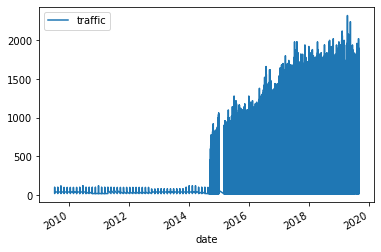

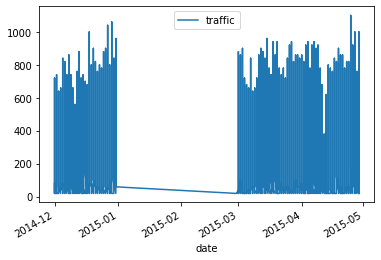

In [31]:
# show why we drop some data:

#time_segment.fillna(0).plot(x='date', y='count')
traffic.plot(x='date', y='traffic')
plt.show()
#traffic
cond_1 = (traffic.date > pd.to_datetime('2014-11-30'))
cond_2 = (traffic.date < pd.to_datetime('2015-04-30'))

traffic[cond_1 & cond_2].plot(x='date', y='traffic')
plt.show()
# It seems that there is a 2-month gap of traffic data for January & February 2015. 
# We shall consider only traffic data after February 2015 (Before 2015 there is no accidents data anyway)

In [32]:
# drop accident data older than March 2015:
cond = (time_segment.date >= pd.to_datetime('2015-03-01'))

time_segment = time_segment[cond]

In [33]:
# merge traffic with accidents:
time_segment = time_segment.merge(traffic, how='left', on=['date', 'hour', 'km_from_addis'])

In [34]:
# Now that we removed missing data we can safely assume that remaining traffic NAs are incidents of 
# no traffic in that particular time-km segment:
time_segment['traffic'] = time_segment['traffic'].fillna(0)

In [35]:
# create features:

# weekday dummies:
time_segment['weekday'] = time_segment.date.apply(lambda x: x.weekday())
time_segment = pd.get_dummies(time_segment, columns=['weekday'])
weekday_dummies = ['weekday_' + str(n) for n in range(7)]

In [36]:
time_segment

,index,date,hour,km_from_addis,accidents,precip_mm,distance_from_addis,case_no,day,hashed_plate_number,vehicle_type,vehicle_brand,direction,road_geometry,road,weather,fatality,serious_injury,slight_injury,cause_of_accident,type_of_accident,year_of_production,owner,driver_age,gender,address,drivers_license_level,license_year,license_region,experience,relation_with_vehicle,etre_asset_damage,ownership,extent_of_damage,year,time_of_accident_minute,accident_datetime,accident_location_original,accident_location_text,latitude,longitude,axle_number,cause_of_accident_simple,type_of_accident_simple,accident_cause_vehicle_human,km,traffic,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,803905,2015-03-01,0,0,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,NaN,0.0,0,0,0,0,0,0,1
1,803906,2015-03-01,0,1000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,NaN,0.0,0,0,0,0,0,0,1
2,803907,2015-03-01,0,2000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,NaN,0.0,0,0,0,0,0,0,1
3,803908,2015-03-01,0,3000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,NaN,0.0,0,0,0,0,0,0,1
4,803909,2015-03-01,0,4000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,NaN,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966241,2770146,2017-12-31,23,74000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,6.0,100.0,0,0,0,0,0,0,1
1966242,2770147,2017-12-31,23,75000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,5.0,100.0,0,0,0,0,0,0,1
1966243,2770148,2017-12-31,23,76000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,4.0,100.0,0,0,0,0,0,0,1
1966244,2770149,2017-12-31,23,77000,0.0,0.0,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,3.0,100.0,0,0,0,0,0,0,1


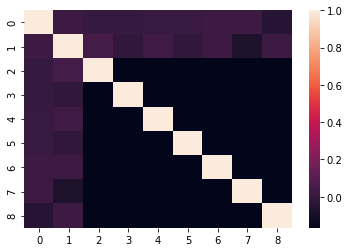

In [37]:
# check for correlation between covariates:
corr = np.corrcoef(X.T[1:])
sns.heatmap(corr)
plt.show()

In [78]:
# OLS model:

y = time_segment.accidents
X = time_segment[['traffic', 'precip_mm'] + weekday_dummies]
X = sm.add_constant(X)

# Fit and summarize OLS model
model = sm.OLS(y, X)

linreg = model.fit()

print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:              accidents   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.295
Date:                Sun, 09 May 2021   Prob (F-statistic):           3.48e-08
Time:                        23:39:33   Log-Likelihood:             4.2546e+06
No. Observations:             1966246   AIC:                        -8.509e+06
Df Residuals:                 1966237   BIC:                        -8.509e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   2.56e-05     19.199      0.0

In [79]:
# Fixed Effects Model:

df = time_segment.set_index(['km_from_addis', 'date']).sort_index()

y = df.accidents
X = df[['traffic', 'precip_mm']]
X = sm.add_constant(X)

mod = PanelOLS(y, X, entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                     2.861e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.1627
No. Observations:             1966246   R-squared (Within):            2.861e-05
Date:                Sun, May 09 2021   R-squared (Overall):          -3.671e-05
Time:                        23:41:15   Log-likelihood                 4.255e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.130
Entities:                          79   P-value                           0.0000
Avg Obs:                    2.489e+04   Distribution:               F(2,1966165)
Min Obs:                    2.489e+04                                           
Max Obs:                     2.49e+04   F-statistic (robust):             7.7174
                            